In [19]:
import pandas as pd
import json
import pickle5 as pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import eval
import plot

pd.options.mode.chained_assignment = None # turns off pandas SettingWithCopyWarning

In [2]:
heuristic90 = 'Path score heuristic, 0.90'
heuristic95 = 'Path score heuristic, 0.95'

thresh95 = -np.log(0.05)
thresh90 = -np.log(0.1)

In [3]:
# load explanations
results_dir = '../../explanations/linklogic/full_parents_benchmark/'
figure_dir = '../../figures/figures_for_paper/'

with open(f'{results_dir}/fb13_child_false.pickle', 'rb') as f:
    results = pickle.load(f)

In [4]:
# load benchmark
with open('../../data/commonsense_benchmark/v4/commonsense_benchmark_all.json', 'r') as f:
    benchmark = json.load(f)
    
print(f'Loaded benchmark with {len(benchmark)} triples')

Loaded benchmark with 6260 triples


In [13]:
rows = []
for i, bmk in tqdm(enumerate(benchmark), total=len(benchmark)):
    triple = bmk['query_triple']

    res = eval.get_results_for_query_triple(results, triple)

    if not res:
        continue

    num_heuristic_paths_90 = sum([1 for f in res['linklogic_features'] if f['kge_score']['path_score'] > thresh90])
    num_heuristic_paths_95 = sum([1 for f in res['linklogic_features'] if f['kge_score']['path_score'] > thresh95])

    rows.append({
        'Query Triple': '--'.join(triple),
        'linklogic Fidelity': res['linklogic_metrics']['test_acc'],
        'Number of Siblings': len(bmk['entity_names']['siblings']),
        'num_paths_linklogic': len(res['linklogic_explanations']),
        'num_paths_heuristic_90': num_heuristic_paths_90,
        'num_paths_heuristic_95': num_heuristic_paths_95
    })
sibs = pd.DataFrame(rows)

100%|██████████| 6260/6260 [00:12<00:00, 493.52it/s]


<Figure size 360x288 with 0 Axes>

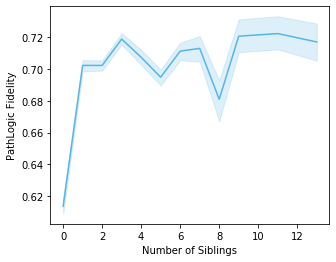

In [23]:
palette = plot.get_categorical_palette()
plt.figure(figsize=(5,4))
g = sns.lineplot(data=sibs, x='Number of Siblings', y='linklogic Fidelity', color=palette['linklogic'])#, ci='sd')
g.get_figure().savefig(f'{figure_dir}Parsimony_D.{plot.figtype}', bbox_inches='tight')

In [16]:
num_paths = sibs.melt(id_vars=['Query Triple', 'Number of Siblings'], value_vars=['num_paths_linklogic', 'num_paths_heuristic_90', 'num_paths_heuristic_95'])
num_paths['variable'] = num_paths['variable'].map({'num_paths_linklogic': 'linklogic', 
                           'num_paths_heuristic_90': heuristic90,
                           'num_paths_heuristic_95': heuristic95})

<Figure size 360x288 with 0 Axes>

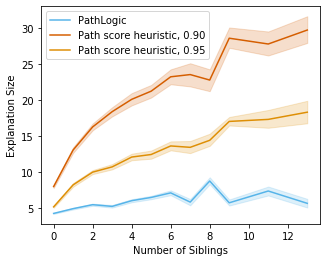

In [22]:
pal = plot.get_categorical_palette()
palette = {'linklogic': pal['linklogic'], heuristic90: pal['Heuristic90'], heuristic95: pal['Heuristic95'] }
plt.figure(figsize=(5,4))
g = sns.lineplot(data=num_paths, x='Number of Siblings', y='value', hue='variable', palette=palette)
_ = g.legend(title='')
_ = g.set(ylabel='Explanation Size')
g.get_figure().savefig(f'{figure_dir}Parsimony_E.{plot.figtype}', bbox_inches='tight')